# Physics-informed Operator

This example demonstrates the training of a physics-informed neural operator.

In [1]:
import torch
import matplotlib.pyplot as plt
from continuity.operators import DeepONet
from continuity.data.losses import PhysicsInformedLoss

In [2]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)


## Problem Statement

Let's assume we want to learn the derivative operator $G: u \mapsto \partial_x u$.
We choose a set of polynomials as input functions $u$.

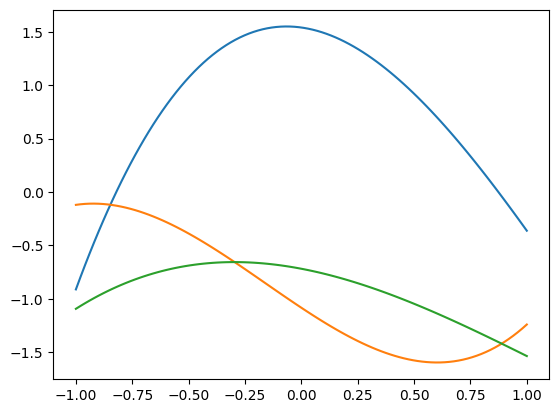

In [3]:
# Input functions are polynomials
degree = 3
def polynomial(coefficients):
    return lambda x: sum(
        coefficients[i] * x ** i
        for i in range(degree+1)
    )

def derivative(coefficients):
    return lambda x: sum(
        coefficients[i+1] * (i+1) * x ** i
        for i in range(degree)
    )

# Generate coefficients
num_functions = 3
a = torch.randn(num_functions, degree+1)

# Plot functions
x = torch.linspace(-1, 1, 100)
for i in range(num_functions):
    u = polynomial(a[i])
    plt.plot(x, u(x))
plt.show()

## Neural Operator

In this example, we use a DeepONet architecture with 32 sensors.

In [4]:
num_sensors = 32

# Define operator
operator = DeepONet(num_sensors)

# Random sensor positions
x = torch.rand(num_sensors) * 2 - 1

## Data set
We define the data set as a list of input functions and evaluation coordinates, but without labels.

In [5]:
# Evaluation points must equal x to compute derivatives and requires grad
x.requires_grad = True

dataset = []
for i in range(num_functions):
    u = polynomial(a[i])
    sample = (x, u(x), x, None)
    dataset.append(sample)

## Physics-informed loss

As we want to learn the derivative operator $G$, we define a physics-informed loss function.

In [6]:
# Derivative
def pde(x, u, y, v):
    u_x = torch.autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
    )[0].reshape(v.shape)
    return ((u_x - v)**2).mean()

loss_fn = PhysicsInformedLoss(pde)

## Training

We train the neural operator using the physics-informed loss function. 

In [7]:
optimizer = torch.optim.Adam(operator.parameters(), lr=1e-3)

operator.compile(optimizer, loss_fn)
operator.fit(dataset, epochs=1000)

Model parameters: 7984
Epoch 1000:  loss = 2.8581e-05  (786.83 it/s)


## Evaluating the trained operator

The trained operator can be evaluated at arbitrary positions, so let's plot a
fine resolution of the mapping along with the target function.

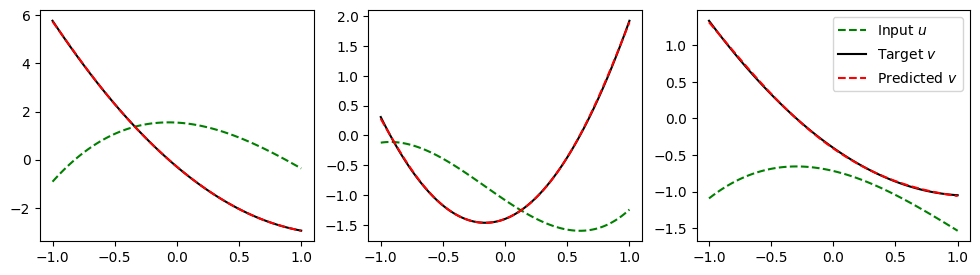

In [8]:
fig, axs = plt.subplots(1, num_functions, figsize=(12, 3))

# Equidistant grid
y = torch.linspace(-1, 1, 100)

# Call operator for polynomials
for i in range(num_functions):
    u = polynomial(a[i])
    v_exact = derivative(a[i])
    v_pred = operator(x, u(x), y)

    # Plot functions
    v_pred = v_pred.reshape(y.shape).detach()
    axs[i].plot(y, u(y), "g--", label="Input $u$")
    axs[i].plot(y, v_exact(y), "k-", label="Target $v$")
    axs[i].plot(y, v_pred, "r--", label="Predicted $v$")
plt.legend()
plt.show()